# LungCT-Diagnosis

name: mohammad mahdi heydari

stu. id: 98209094

In [1]:
!pip install pydicom

In [2]:
from model import ResNet3D, ResBlock3D
from functions import *
from dataset import LungCT_Dataset

import os
import gc
import glob
import time
import pickle
import random

import cv2
import torch
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
from pydicom import dcmread
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## data exploration

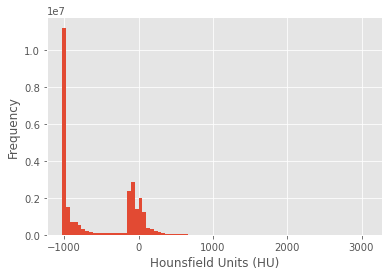

In [4]:
temp = load_scan('./CT_Scan/CT_Scan/LungCT-Diagnosis/R_053')
temp_pixels = get_pixels_hu(temp)
plt.hist(temp_pixels.flatten(), bins=80)
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

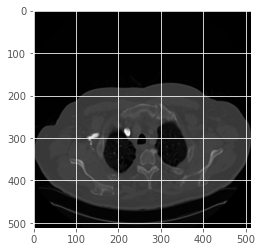

In [9]:
plt.imshow(temp_pixels[14], cmap=plt.cm.gray)
plt.show()

In [10]:
temp_resampled = resample(temp_pixels, temp)
print("Shape before resampling\t", temp_pixels.shape)
print("Shape after resampling\t", temp_resampled.shape)

Shape before resampling	 (104, 512, 512)
Shape after resampling	 (89, 128, 128)


<ipython-input-17-80688e2fcf5a>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_3d(temp_resampled, 400).show()


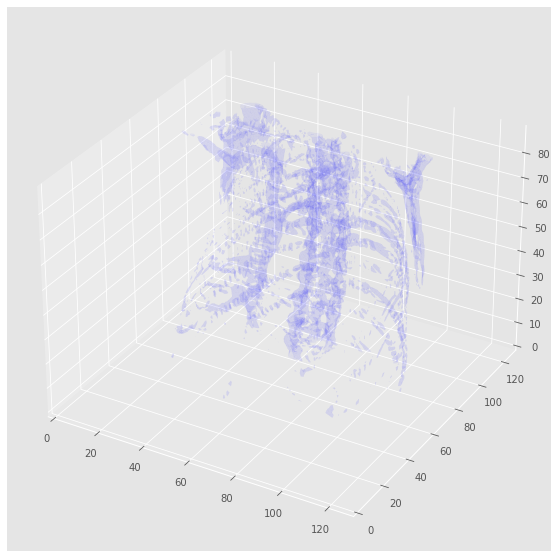

In [17]:
plot_3d(temp_resampled, 400).show()

C:\Users\moham\Desktop\image proccessing\hw_2\functions.py:119: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, allow_degenerate=True)
<ipython-input-13-638ea90b43b8>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_3d(segmented_lungs, None).show()


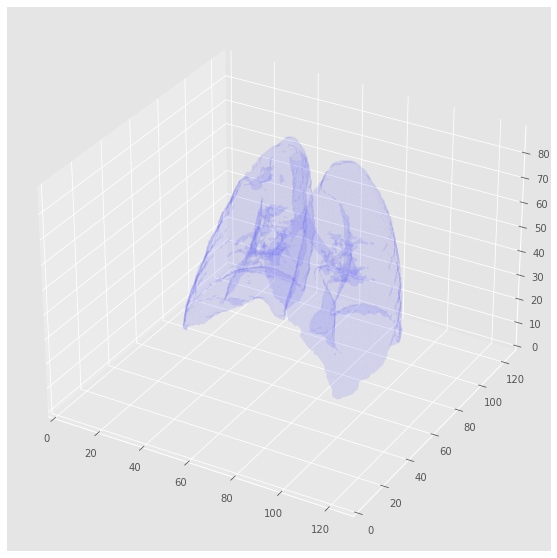

In [13]:
segmented_lungs = segment_lung_mask(temp_resampled)
plot_3d(segmented_lungs, None).show()

## load dataset from images

In [18]:
vital_status = pd.read_csv('./vital_status.csv')
vital_status = vital_status[~vital_status['Patient Identifier'].isin(['Patient_019','Patient_172','Patient_267'])].values
dataset = LungCT_Dataset('./CT_Scan/CT_Scan/LungCT-Diagnosis/',
                         vital_status.tolist(), 128)

start loading dataset...

dataset loaded successfully


## save dataset to pickle

here we want to save to dataset in order to save time loading it without the preproccessing steps.

In [19]:
pickle.dump(dataset, open("dataset.p", "wb"))

## load the dataset from pickle

for later use we can use this section in order to load the dataset from pickel file.

In [4]:
dataset = pickle.load(open("dataset.p", "rb"))

## split the data

In [5]:
BATCH_SIZE = 4

dataset_size = len(dataset)
test_size = dataset_size * 2 // 10
train_size = dataset_size - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

## K-Fold cross validation

In [24]:
K = 5
epochs = 100

metrics = {
    'accuracy': []
}

indices = np.array(range(len(train_dataset)))
np.random.shuffle(indices)
folds = np.array_split(indices, 5)

criterion = torch.nn.CrossEntropyLoss().to(device)

for k in tqdm(range(K), desc='Folds', leave=True):
    tqdm.write("Begin fold %d" % k)

    model = ResNet3D().to(device)
    optimizer = torch.optim.Adam(model.parameters())

    gc.collect()
    torch.cuda.empty_cache()

    hist = {
        'loss': {'train':[], 'validation':[]},
        'accuracy': {'train':[], 'validation':[]},
    }

    def reporter(epoch, model, train_stat, validation_stat):

        hist['loss']['train'].append(train_stat[0])
        hist['accuracy']['train'].append(train_stat[1])

        hist['loss']['validation'].append(validation_stat[0])
        hist['accuracy']['validation'].append(validation_stat[1])

        tqdm.write("epoch %02d | loss: %.5f %.5f | accuracy: %.2f%% %.2f%%" % (epoch + 1, train_stat[0], validation_stat[0], train_stat[1] * 100, validation_stat[1] * 100))

        if (epoch + 1) % 20 == 0:
            tqdm.write('sleeping 20 seconds')
            time.sleep(20)

    tdl = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=indices[~np.isin(indices, folds[k])])
    vdl = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=folds[k])

    train(epochs, device, model, criterion, optimizer, tdl, vdl, lambda x: (x[0], x[2]), reporter)
    metrics['accuracy'].append(hist['accuracy']['validation'])

    fig, (ax1, ax2) = plt.subplots(2)
    fig.subplots_adjust(hspace=0.5)

    ax1.plot(hist['accuracy']['train'], label='train')
    ax1.plot(hist['accuracy']['validation'], label='validation')
    ax1.set_title("accuracy")
    ax1.legend()

    ax2.plot(hist['loss']['train'], label='train')
    ax2.plot(hist['loss']['validation'], label='validation')
    ax2.set_title("loss")
    ax2.legend()

    tqdm.write('sleeping 30 seconds')
    time.sleep(30)

In [39]:
accuracies = [np.max(x) for x in metrics['accuracy']]
print("maximum fold validation accuracy:")
print("  ".join([("%.03f%%" % (x * 100)) for x in accuracies]))
print("\naverage:")
print("%.03f %%" % np.mean(accuracies))

maximum fold validation accuracy:
91.667%  83.333%  83.333%  83.333%  91.667%

average:
0.867 %


## test the model

epoch 01 | loss: 0.80308 1.57888 | accuracy: 61.81% 27.78%
epoch 02 | loss: 0.74350 2.07435 | accuracy: 67.36% 30.56%
epoch 03 | loss: 0.71873 4.98237 | accuracy: 59.72% 69.44%
epoch 04 | loss: 0.68877 3.62244 | accuracy: 59.72% 75.00%
epoch 05 | loss: 0.64543 0.69498 | accuracy: 63.19% 55.56%
epoch 06 | loss: 0.68278 0.70857 | accuracy: 60.42% 52.78%
epoch 07 | loss: 0.66620 0.89205 | accuracy: 61.81% 27.78%
epoch 08 | loss: 0.64210 0.61979 | accuracy: 65.97% 61.11%
epoch 09 | loss: 0.63714 0.89246 | accuracy: 61.81% 38.89%
epoch 10 | loss: 0.63251 1.21980 | accuracy: 61.11% 25.00%
epoch 11 | loss: 0.59549 0.76436 | accuracy: 68.75% 61.11%
epoch 12 | loss: 0.64744 0.49439 | accuracy: 61.81% 66.67%
epoch 13 | loss: 0.68803 0.52996 | accuracy: 60.42% 72.22%
epoch 14 | loss: 0.62523 0.50793 | accuracy: 70.83% 77.78%
epoch 15 | loss: 0.54359 0.77482 | accuracy: 78.47% 72.22%
epoch 16 | loss: 0.60676 1.58943 | accuracy: 74.31% 25.00%
epoch 17 | loss: 0.65783 0.50799 | accuracy: 66.67% 75.0

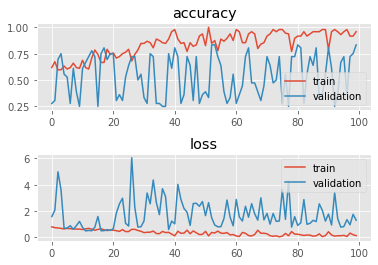

In [41]:
model = ResNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters())

gc.collect()
torch.cuda.empty_cache()

hist = {
    'loss': {'train':[], 'validation':[]},
    'accuracy': {'train':[], 'validation':[]},
}

def reporter(epoch, model, train_stat, validation_stat):

    hist['loss']['train'].append(train_stat[0])
    hist['accuracy']['train'].append(train_stat[1])

    hist['loss']['validation'].append(validation_stat[0])
    hist['accuracy']['validation'].append(validation_stat[1])

    tqdm.write("epoch %02d | loss: %.5f %.5f | accuracy: %.2f%% %.2f%%" % (epoch + 1, train_stat[0], validation_stat[0], train_stat[1] * 100, validation_stat[1] * 100))

    if (epoch + 1) % 20 == 0:
        tqdm.write('sleeping 20 seconds')
        time.sleep(20)

train(epochs, device, model, criterion, optimizer, train_loader, test_loader, lambda x: (x[0], x[2]), reporter)
metrics['accuracy'].append(hist['accuracy']['validation'])

fig, (ax1, ax2) = plt.subplots(2)
fig.subplots_adjust(hspace=0.5)

ax1.plot(hist['accuracy']['train'], label='train')
ax1.plot(hist['accuracy']['validation'], label='validation')
ax1.set_title("accuracy")
ax1.legend()

ax2.plot(hist['loss']['train'], label='train')
ax2.plot(hist['loss']['validation'], label='validation')
ax2.set_title("loss")
ax2.legend()

## save the model

In [43]:
torch.save(model, 'model-128-8.pth')

## load the model

In [13]:
model = torch.load('model-128-8.pth', map_location=device)

In [44]:
real = []
pred = []
names = []

with torch.no_grad():
        model.eval()

        for inputs, _, labels, nn in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze(1)
            real += labels.cpu().detach().numpy().tolist()
            pred += (torch.nn.functional.softmax(outputs.cpu().detach(), dim=1))
            names += nn

(["%d -> %s" % (x, y) for x,y in zip(real, pred)])

['1 -> tensor([0.2361, 0.7639])',
 '1 -> tensor([0.2955, 0.7045])',
 '1 -> tensor([1.0470e-04, 9.9990e-01])',
 '0 -> tensor([0.9059, 0.0941])',
 '1 -> tensor([0.0215, 0.9785])',
 '0 -> tensor([1.7108e-05, 9.9998e-01])',
 '1 -> tensor([0.0023, 0.9977])',
 '0 -> tensor([0.0191, 0.9809])',
 '1 -> tensor([1.0796e-06, 1.0000e+00])',
 '1 -> tensor([1.5618e-06, 1.0000e+00])',
 '1 -> tensor([0.0100, 0.9900])']

In [45]:
print(classification_report(real, np.array([x.numpy() for x in pred]).argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.80      1.00      0.89         8

    accuracy                           0.82        11
   macro avg       0.90      0.67      0.69        11
weighted avg       0.85      0.82      0.78        11



Patient_043
predicted:  1


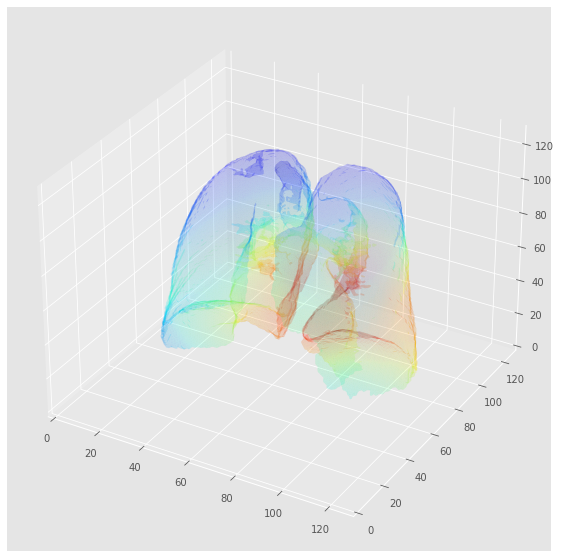

In [75]:
index = 10
print(dataset[index][3])
cam = cam_visualize(device, dataset, index, model)
i,j,k = np.unravel_index(cam.argmax(), cam.shape)

In [76]:
foldername = dataset[index][3].replace('Patient', 'R')
image = load_scan('./CT_Scan/CT_Scan/LungCT-Diagnosis/' + foldername)
pixels = get_pixels_hu(image)
scaled = resample(pixels, image, 128)
padded = pad(scaled, 128)

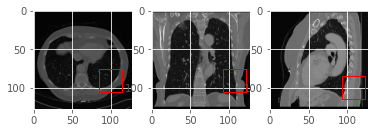

In [77]:
fig,ax = plt.subplots(1,3)

ax[0].imshow(padded[i, :, :], cmap='gray')
ax[0].add_patch(patches.Rectangle((j,k),30,30,linewidth=1,edgecolor='r',facecolor='none'))

ax[1].imshow(padded[:, j, :], cmap='gray')
ax[1].add_patch(patches.Rectangle((i,k),30,30,linewidth=1,edgecolor='r',facecolor='none'))

ax[2].imshow(padded[:, :, k], cmap='gray')
ax[2].add_patch(patches.Rectangle((i,j),30,30,linewidth=1,edgecolor='r',facecolor='none'))

plt.show()